Please make sure you have MorphoPy installed before executing this Tutorial

In [1]:
# To delete when installation works
import sys
sys.path.append("../")

from morphopy.computation import file_manager as fm
from morphopy.neurontree import NeuronTree as nt
import pandas as pd
import networkx as nx
import numpy as np

# Load file

Files can be loaded using the integrated file manager. By default, the file manager reads in the swc file and standardizes it to be soma centered. 

In [2]:
filename = "EC3-80604.CNG.rotated.swc"
N = fm.load_swc_file("../data/" + filename)

# Plotting

Each NeuronTree object comes with its own plotting function `draw_2D()`. The parameter `projection` let's you choose which 2D projection to plot.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

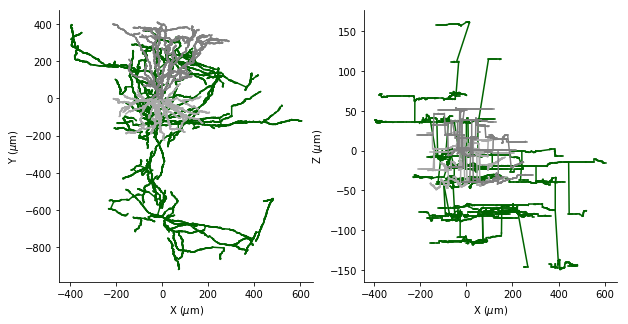

In [4]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
N.draw_2D(fig, ax=ax1, projection='xy')


ax2= plt.subplot(122)
N.draw_2D(fig, ax=ax2, projection='xz')

In order to see all of the three possible 2D projections at once you can also use the provided `show_threeview()`

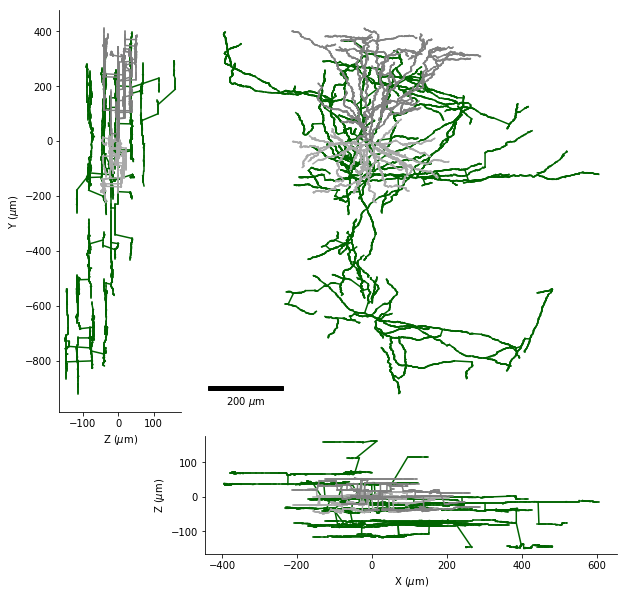

In [7]:
from morphopy.neurontree.plotting import show_threeview

fig = plt.figure(figsize=(10,10))
show_threeview(N, fig)

### Plotting axon and dendrites and neurites independently

In the plot above, the axon is large and entangled with the dendrites, so you might want to look at axons and dendrites independently. This can be done through the `get_axonal_tree()` and `get_dendritic_tree()` methods. 

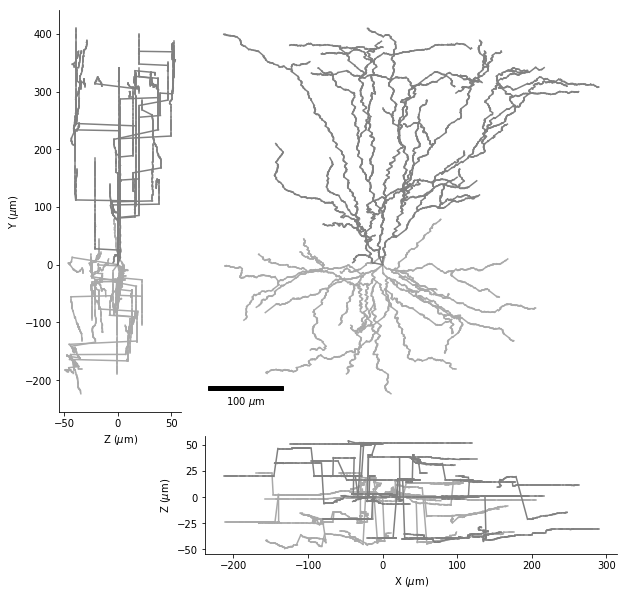

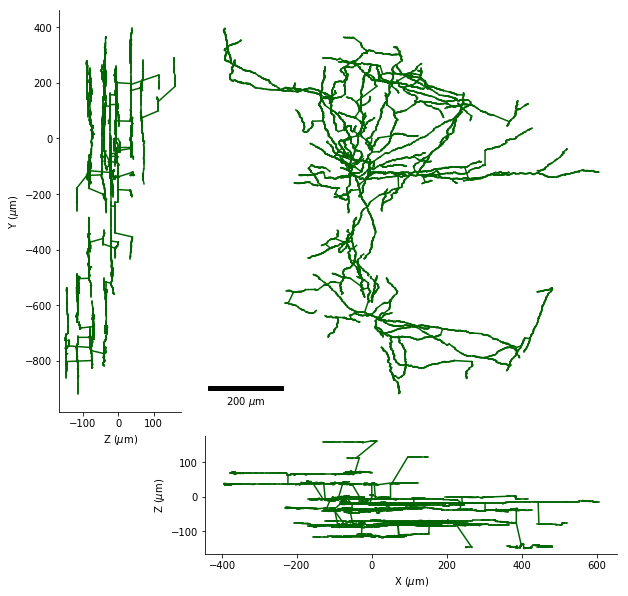

In [9]:
Axon = N.get_axonal_tree()
Dendrites = N.get_dendritic_tree()

dendrite_fig = plt.figure(figsize=(10,10))
show_threeview(Dendrites, dendrite_fig)


axon_fig = plt.figure(figsize=(10,10))
show_threeview(Axon, axon_fig)

`get_neurites()` returns a list of all neurites that extend from the soma. This can be used, for example, to examine each neurite individually. 

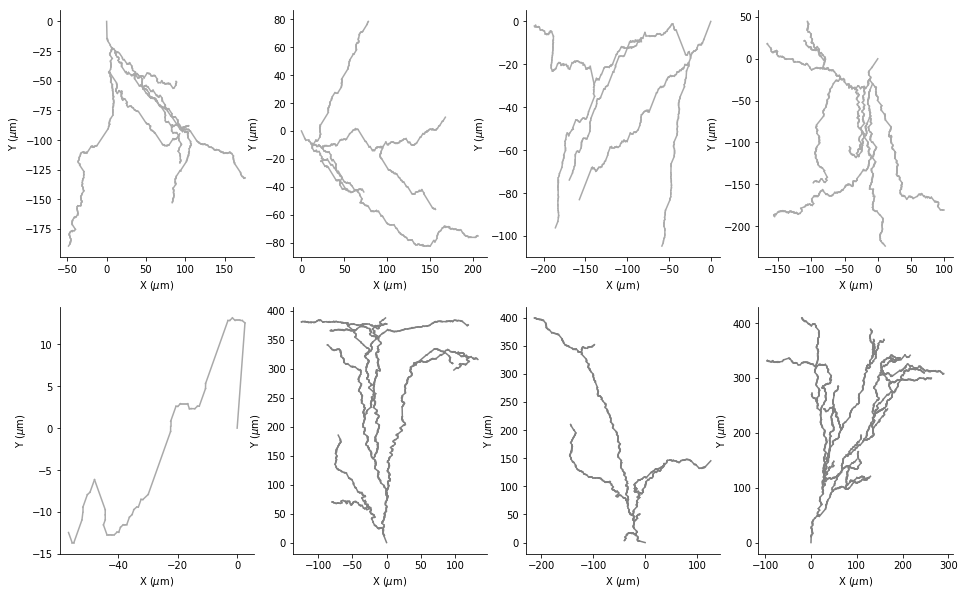

In [10]:
neurites = Dendrites.get_neurites()

fig = plt.figure(figsize=(16,10))
for k in range(len(neurites)):
    ax = plt.subplot(2,4, k+1)
    neurites[k].draw_2D(fig, ax, projection='xy')

# Downsampling a morphology

Reconstruction files can have several thousand nodes. Sometimes it makes sense to reduce a reconstruction by e.g. resampling or different techniques. MorphoPy offers two functions for this: `resample_tree(dist)` and `get_topological_minor()`.

`resample_tree(dist)` returns a new NeuronTree where all points along a path are resampled to have the specified distance `dist`. Original branch points will be kept. If a branch is smaller than the specified distance it will get pruned away.

In [11]:
dendrite = neurites[5]
T5 = dendrite.resample_tree(dist=5)
T20 = dendrite.resample_tree(dist=20)

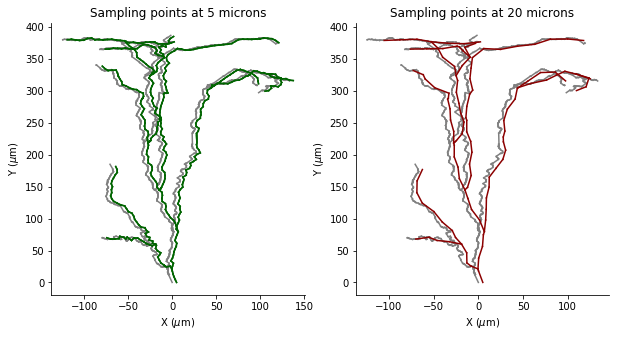

In [12]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
dendrite.draw_2D(fig,ax1, projection='xy')
T5.draw_2D(fig, ax1, projection='xy',x_offset=5, apical_dendrite_color='darkgreen') # plotted with an offset to improve visualisation
sns.despine()
plt.title('Sampling points at 5 microns')


# Note at this sampling resolution the tips start to get pruned away. 
ax2 = plt.subplot(122)
dendrite.draw_2D(fig,ax2, projection='xy')
T20.draw_2D(fig,ax2, projection='xy',x_offset=5, apical_dendrite_color='darkred') # plotted with an offset to improve visualisation
sns.despine()
plt.title('Sampling points at 20 microns')

The method `get_topological_minor()` reduces a reconstruction to its branch points and tips. All nodes along a path will be pruned away. This is called a topological minor. It can be useful if the metric you are interested in does not depend on the exact neurite paths and you want to speed up your computation.

The original path length of the now reduced edge is kept as an edge attribute `path_length`.

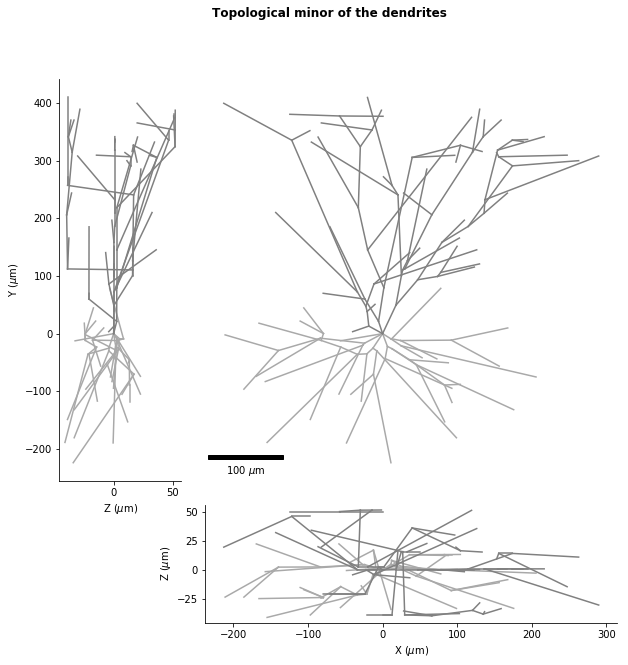

In [13]:
D = Dendrites.get_topological_minor()

fig = plt.figure(figsize=(10,10))
show_threeview(D, fig)
plt.suptitle('Topological minor of the dendrites', weight='bold')

In [14]:
total_length_unreduced = np.sum(list(Dendrites.get_segment_length(dist='path_length').values()))
print('Total length of unreduced dendrites: %.2f microns'%total_length_unreduced)

total_length_reduced = np.sum(list(D.get_segment_length(dist='path_length').values()))
print('Total length of reduced dendrites: %.2f microns'%total_length_reduced)


Total length of unreduced dendrites: 12014.34 microns
Total length of reduced dendrites: 12014.34 microns


# Computing feature representations

MorphoPy offers to the extraction of different feature representations that can be grouped into four categories: 
- Density Maps
- Morphometric Statistics
- Morphometric Distributions
- Persistence Diagrams

## Computing Density Maps

Density maps are marginal histograms over the neural mass. MorphoPy allows you to create density maps of different projections through the function `compute_density_maps()`.
Per default it computes x, y, z, xy, xz and yz density maps from the point cloud of the original reconstruction. The point cloud (pc) is constructed through resampling along all neurites with a default distance of 1 micron. The resulting pc is then binned into bins of 20 microns and smoothed using Gaussian smoothing with std of 1. 

You can customize all these parameters by passing a `config_param` dictionary to the function.

Possible parameters to pass are: 
    - distance: (default=1, in microns) determines the resampling distance.
    - bin_size: (default=20, in microns). If set the number of bins will be computed such that one bin 
    spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
    - n_bins_x/y/z: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
    `bin_size` flag.
    - density: (default=True) bool to specify if a density or counts are returned.
    - smooth: (default=True) bool to trigger Gaussian smoothing.
    - sigma: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
    - r_min_x/y/z: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
    minimal histogram edge. 
    - r_max_x/y/z: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
    maximal histogram edge. 

Parameters that are not passed are set to their default value. 

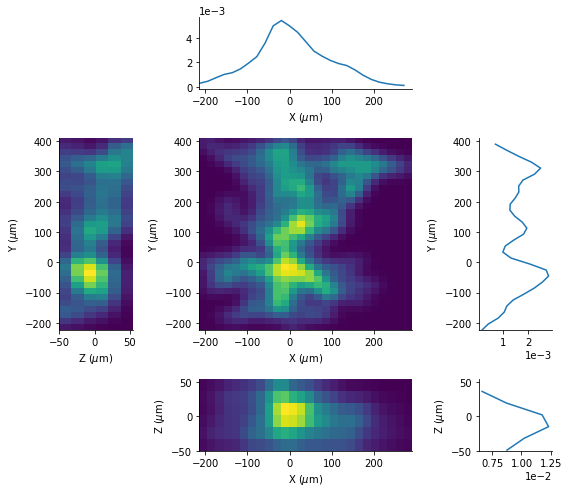

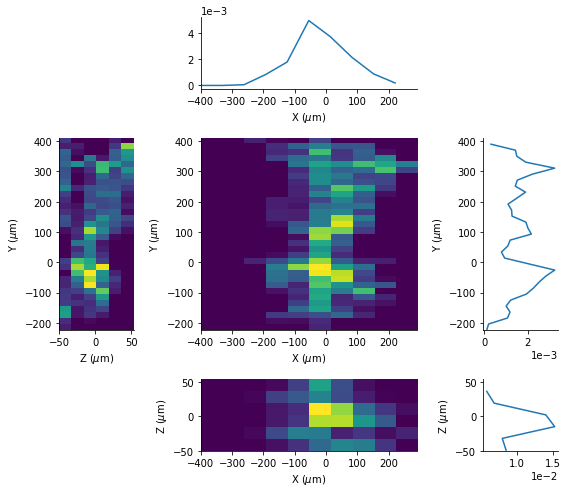

In [16]:
from morphopy.computation.feature_presentation import compute_density_maps, plot_density_maps

# Compute density maps with default parameters
densities_default = compute_density_maps(Dendrites)

# Compute density maps with custom parameters
config = {'n_bins_x': 10 , 'smooth': False, 
          'r_min_x': -400}
densities_custom = compute_density_maps(Dendrites, config)

# plot all maps
plots = plot_density_maps(densities_default)
_ = plot_density_maps(densities_custom)

## Compute Morphometric Statistics

MorphoPy offers a default selection of 28 single-valued morphometric statistics.

In [17]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics

morph_wide = compute_morphometric_statistics(N)
morph_wide['filename'] = filename
morph_wide.set_index('filename')

,stems,branch_points,total_volume,max_degree,min_path_angle,log_max_tortuosity,max_branch_order,median_terminal_segment_pl,log_min_tortuosity,total_length,...,depth,tips,height,max_segment_path_length,median_path_angle,median_intermediate_segment_pl,min_branch_angle,mean_branch_angle,tree_asymmetry,avg_thickness
filename,,,,,,,,,,,,,,,,,,,,,
EC3-80604.CNG.rotated.swc,9.0,216.0,18057.345281,2.0,0.0,0.823007,36.0,54.729019,0.0,32329.232882,...,1328.61,224.0,310.68,583.527555,19.203974,40.050082,11.866698,95.859946,0.814848,0.235766


By default, the method returns the data in the wide data format but it is possible to adjust this to the long data format by setting the parameter `format`. 

In [18]:
morph_long = compute_morphometric_statistics(N, format='long')
morph_long['filename'] = filename
morph_long

,statistic,value,filename
0,stems,9.000000,EC3-80604.CNG.rotated.swc
1,branch_points,216.000000,EC3-80604.CNG.rotated.swc
2,total_volume,18057.345281,EC3-80604.CNG.rotated.swc
3,max_degree,2.000000,EC3-80604.CNG.rotated.swc
4,min_path_angle,0.000000,EC3-80604.CNG.rotated.swc
5,log_max_tortuosity,0.823007,EC3-80604.CNG.rotated.swc
6,max_branch_order,36.000000,EC3-80604.CNG.rotated.swc
7,median_terminal_segment_pl,54.729019,EC3-80604.CNG.rotated.swc
8,log_min_tortuosity,0.000000,EC3-80604.CNG.rotated.swc
9,total_length,32329.232882,EC3-80604.CNG.rotated.swc


You can find the particular computations of each preselected morphometric statistic in the `compute_morphometric_statistics()` method. Here you can also adjust the code to only compute a subset of these features.
If you want to add completely different features, please check out the documentation of the neurontree object's functionality.



## Computing Morphometric Distributions

MorphoPy offers a range of different morphometric distributions via the `get_histogram(key, dist_measure=None, **kwargs)` method. If no `dist_measure` is passed the distributions are typically one-dimensional. `**kwargs` allows to pass parameters to the numpy.histogramdd method. 

Possible keys for statistics are:

    - branch orders
    - Strahler order
    - branch angles
    - path angles
    - root angles
    - thickness
    - segment lengths
    - path length to soma
    - radial distance

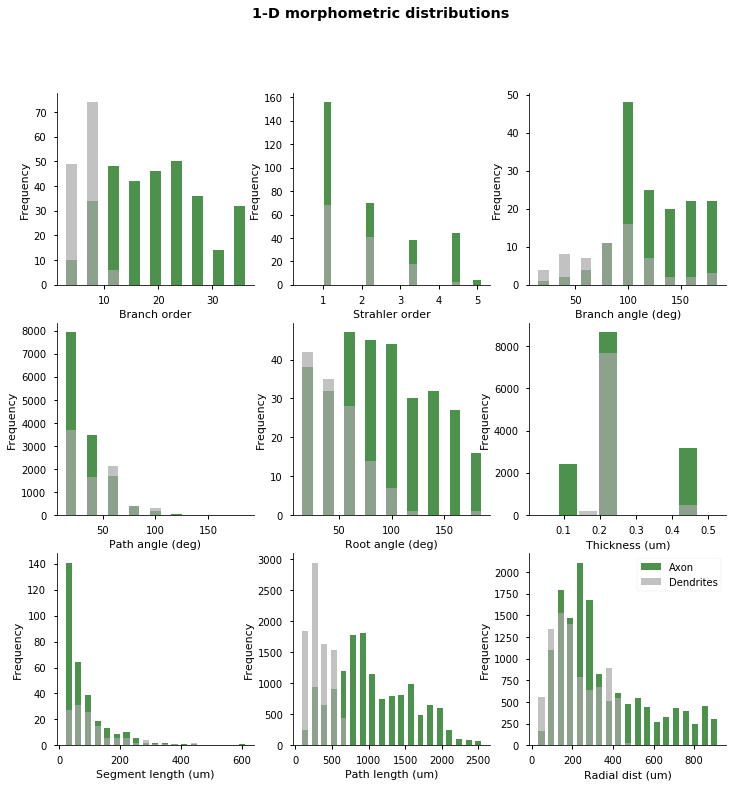

In [19]:
# show morphometric distributions for axon and dendrites separately. 
sns.set_context('notebook')
statistics = ['branch_order', 'strahler_order', 
              'branch_angle', 'path_angle', 'root_angle', 
              'thickness', 'segment_length', 'path_length', 'radial_dist']

hist_widths = [2,.2, 10, 10, 10, .05, 20, 80, 30]
limits = [35, 5, 180, 180, 180, 0.5, 600, 2500, 900]
A = Axon.get_topological_minor()
D = Dendrites.get_topological_minor()

plt.figure(figsize=(12,12))
k = 1
for stat, lim, w in zip(statistics,limits, hist_widths):
    plt.subplot(3,3,k)
    for Trees, c in [[(Axon, A), 'darkgreen'], [(Dendrites, D), 'darkgrey']]:
        if stat in ['segment_length', 'path_length', 'radial_dist']:
            bins = np.linspace(0,lim, 20)
        else:
            bins= np.linspace(0,lim, 10)
        if stat in ['branch_order', 'strahler_order', 'root_angle']:
            dist, edges = Trees[1].get_histogram(stat, bins=bins)
        else:    
            dist, edges = Trees[0].get_histogram(stat, bins=bins) # you can pass options to the histogram method

        
        plt.bar(edges[1:], dist, width=w, color=c, alpha=.7)
        sns.despine()
        xlabel = stat.replace("_", " ").capitalize()
        if xlabel.find('length') > -1 or xlabel.find('dist') > -1 or xlabel == 'Thickness':
            xlabel += ' (um)'
        elif xlabel.find('angle') > -1:
            xlabel += ' (deg)'
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')

    k+=1

plt.legend(['Axon', 'Dendrites'])
plt.suptitle('1-D morphometric distributions', weight='bold')


All 1D distributions can also be queried with a distance function via the parameter `dist_measure`. This is a good way to see their spatial progression with distance to the soma, the returned distribution then becomes two-dimensional.


In [20]:
dist_both, edges_both = Axon.get_histogram('branch_angle', dist_measure='radial_dist', density=True)
dist_ba , edges_ba = Axon.get_histogram('branch_angle', density=True)
dist_r , edges_r = Axon.get_histogram('radial_dist', density=True)

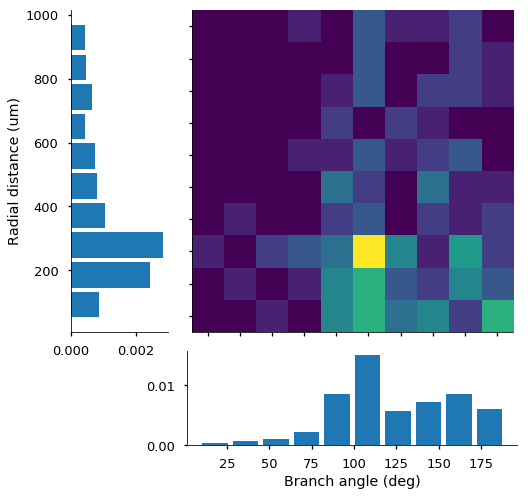

In [21]:
sns.set_context('talk')
plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((4, 4), (0, 1), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=1)
ax3 = plt.subplot2grid((4, 4), (3, 1), rowspan=1, colspan=3)


ax1.imshow(dist_both) 
ax1.set_xticks(range(len(edges_both[1])-1))
ax1.set_xticklabels('')
ax1.set_yticks(range(len(edges_both[0])-1))
ax1.set_yticklabels('')
ax1.invert_yaxis()

ax3.bar(edges_ba[1:], dist_ba, width=15)
sns.despine()
ax3.set_xlabel('Branch angle (deg)')

ax2.barh(edges_r[1:], dist_r, height=80)
ax2.set_ylabel('Radial distance (um)')

These distribution plots tell us that the axon starts branching heavily about 200-300 microns away from the soma and its branching angles tend to be large (>70).

## Gaussian kernel density estimates
The same distributions shown above can also be queried as smoothed Gaussian kernel density estimates.

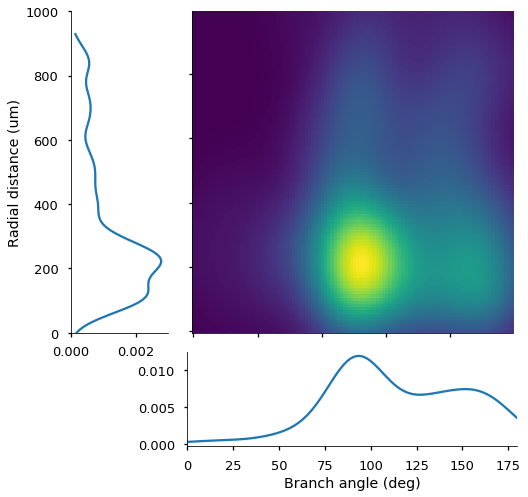

In [22]:
# Get the kernel density estimate
kde_both,sampling_positions = Axon.get_kde_distribution('branch_angle', dist_measure='radial_dist')
kde_ba, x_ba  = Axon.get_kde_distribution('branch_angle')
kde_r, x_r = Axon.get_kde_distribution('radial_dist')


Z = np.reshape(kde_both(sampling_positions).T, (100,100)) # the method returns 100 sampling point per dimension


# Plot data
sns.set_context('talk')
plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((4, 4), (0, 1), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=1)
ax3 = plt.subplot2grid((4, 4), (3, 1), rowspan=1, colspan=3)


ax1.imshow(Z) 
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.invert_yaxis()

ax3.plot(x_ba, kde_ba(x_ba))
ax3.set_xlim([0,180])
sns.despine()
ax3.set_xlabel('Branch angle (deg)')


ax2.plot(kde_r(x_r), x_r)
ax2.set_ylim([0,1000])
ax2.set_xlim([0,0.003])
ax2.set_ylabel('Radial distance (um)')

### Sholl intersection profiles

A special distribution not mentioned yet is the Sholl intersection profile. It counts how often a 2D projection of the neural arbors intersects with concentric circles of growing radius (idea developed [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1244622/)). The center is usually placed at the soma. In our implementation one can also choose to use the centroid of the arbors' convex hull as a center point.

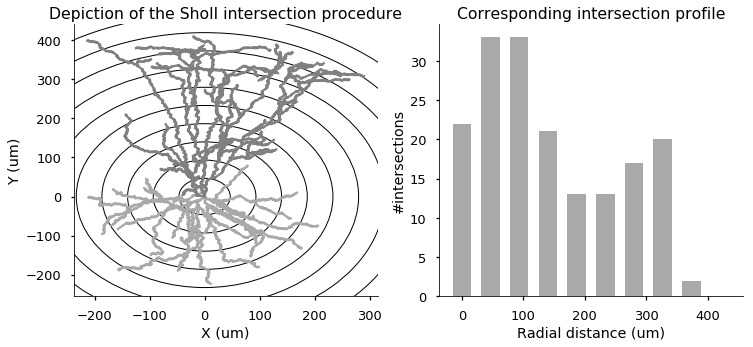

In [23]:
from matplotlib.patches import Circle

# get the sholl intersection profileof the xy projection using 10 circles and the soma as center. 
counts, radii = Dendrites.get_sholl_intersection_profile(proj='xy', steps=10, centroid='soma')

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
Dendrites.draw_2D(fig, projection='xy')
sns.despine()
ax1.set_xlabel('X (um)')
ax1.set_ylabel('Y (um)')

for r in radii:
    
    circ = Circle((0,0),r, edgecolor='k', facecolor=None, fill=False, linewidth=1)
    ax1.add_artist(circ)

plt.title('Depiction of the Sholl intersection procedure')    

    
ax2 = plt.subplot(122)
ax2.bar(radii[:-1], counts, color='darkgrey', width=30)
sns.despine()
ax2.set_xlabel('Radial distance (um)')
ax2.set_ylabel('#intersections')
plt.title('Corresponding intersection profile')  

## Computing the Persistence Diagram

By default MorphoPy implements four different distance functions for persistence diagrams: radial distance to soma, path length to soma, height to soma, and branch order (to be found in computations.persistence_functions).


In [25]:
from morphopy.computation.persistence_functions import path_length, radial_distance, height, branch_order
from morphopy.computation.feature_presentation import get_persistence

filter_function = path_length

df = get_persistence(N.get_topological_minor(), f=filter_function) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,486.073417,470.160387,7911,4
1,522.800246,486.818628,3914,4
2,1994.379577,1908.624784,14377,2
3,850.819503,829.063645,19423,2
4,1056.366112,1049.577887,15814,2


However, one can also provide a custom distance function. It only needs to follow the form `function(networkx.DiGraph(), node_id_end, node_id_start)` and return the distance between start node and end node.

In [21]:
import numpy as np
def custom_distance(G, u, v):
    """
    Returns a distance between nodes u and v, which both are part of the graph given in G.
    """
    if np.float(nx.__version__) < 2: 
        n = G.node[u]['pos']
        r = G.node[v]['pos']
    else:
        n = G.nodes[u]['pos']
        r = G.nodes[v]['pos']
    return np.dot(n - r, [0,0,1])



df = get_persistence(N.get_topological_minor(), f=custom_distance) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,0.99,0.99,7911,4
1,15.61,16.74,3914,4
2,-38.94,-38.71,14377,2
3,37.42,40.46,19503,2
4,-80.76,-80.76,15814,2


# Batchwise feature extraction

So far we only have shown how to extract features from a single cell. In the following we show a code template for looping through a folder of reconstructions.

In [26]:
import os

# get the data from a folder
# path = 'PATH TO FOLDER'
# root, _, files = list(os.walk(path))[0]

# or provide as a list
files = ['Image001-005_01_CNenhance_latest_LXS.swc', 'C4.swc', 
         'EC3-80604.CNG.rotated.swc' , 
         'V1_Layer23_Chat-IRES-Cre-neo_Ai14-299537.04.02.01_614430666_m.swc']

root = '../data/'

morphometrics = pd.DataFrame()
for k, f in enumerate(files):
    if f.find('swc') > -1:
        try: 
            neuron = fm.load_swc_file(root + f)
            m = compute_morphometric_statistics(neuron)
            # don't forget to add a filename or another identifier
            m['filename'] = f
            m['id'] = k
            morphometrics = morphometrics.append(m)
        except ValueError:
            continue
# resetting the index
morphometrics.set_index('id')

,stems,branch_points,total_volume,max_degree,min_path_angle,log_max_tortuosity,max_branch_order,median_terminal_segment_pl,log_min_tortuosity,total_length,...,tips,height,max_segment_path_length,median_path_angle,median_intermediate_segment_pl,min_branch_angle,mean_branch_angle,tree_asymmetry,avg_thickness,filename
id,,,,,,,,,,,,,,,,,,,,,
0,6.0,108.0,0.000000,3.0,0.0,0.795180,13.0,40.045395,0.000000,11104.929995,...,114.0,112.000000,312.828473,0.000000,28.852642,15.851862,89.529585,0.710673,0.000000,Image001-005_01_CNenhance_latest_LXS.swc
1,3.0,76.0,0.000000,3.0,0.0,0.727037,9.0,51.495345,0.047387,6040.598910,...,79.0,26.600001,161.600527,45.000000,17.094742,4.662374,60.753786,0.580736,0.000000,C4.swc
2,9.0,216.0,18057.345281,2.0,0.0,0.823007,36.0,54.729019,0.000000,32329.232882,...,224.0,310.680000,583.527555,19.203974,40.050082,11.866698,95.859946,0.814848,0.235766,EC3-80604.CNG.rotated.swc
3,3.0,57.0,1278.335007,2.0,0.0,0.563902,14.0,29.198583,0.000618,4831.861671,...,59.0,110.852800,277.310031,5.953489,31.001369,3.725956,72.197653,0.734318,0.197157,V1_Layer23_Chat-IRES-Cre-neo_Ai14-299537.04.02...
